In [3]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 932.4 kB/s eta 0:00:00


In [2]:
"""'Age', 'Gender', 'Education', 'Income', 'Joining_Designation', 'Grade',
       'Total_Business_Value', 'Last_Quarterly_Rating',
       'Quarterly_Rating_Increased', 'Income_Increased'"""

"'Age', 'Gender', 'Education', 'Income', 'Joining_Designation', 'Grade',\n       'Total_Business_Value', 'Last_Quarterly_Rating',\n       'Quarterly_Rating_Increased', 'Income_Increased'"

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from scipy.stats import skew
import joblib
import pickle
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , roc_auc_score, classification_report, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report



In [6]:
path="/content/ola_driver.csv"
df=pd.read_csv(r"{path}".format(path=path))

In [7]:
# dropping Unnamed: 0 col
df.drop(columns="Unnamed: 0",inplace=True)

In [8]:
df.head()

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [11]:
# converting objects to datetime format
df['Dateofjoining']=pd.to_datetime(df['Dateofjoining'],errors='coerce')
df['LastWorkingDate']=pd.to_datetime(df['LastWorkingDate'],errors='coerce')

<ipython-input-11-077a24ae3f13>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dateofjoining']=pd.to_datetime(df['Dateofjoining'],errors='coerce')
<ipython-input-11-077a24ae3f13>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['LastWorkingDate']=pd.to_datetime(df['LastWorkingDate'],errors='coerce')


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  object        
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

In [13]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1


In [15]:
# groupping over driverid to have our data behaviour consistent
def check(x):
    val = x.unique()
    return val[-1]

groups = df.groupby("Driver_ID")
dfg = groups.agg(
    total_months=("MMM-YY" ,"count"),
    age=('Age','last'),
    gender=('Gender',"first"),
    city=("City",'last'),
    education=("Education_Level" , "last"),
    income=("Income",'last'),
    DOJ= ("Dateofjoining" , 'first'),
    LWD= ("LastWorkingDate" , check) ,
    joining_designation=("Joining Designation" , 'first'),
    grade=("Grade" , 'last'),
    total_business_val=("Total Business Value" , "sum"),
    quarterly_rating=("Quarterly Rating" , 'mean')
).reset_index()

In [16]:
print(f"Total number of unique driverID : {groups.ngroups}")

Total number of unique driverID : 2381


In [17]:
dfg.isna().sum()

,0
Driver_ID,0
total_months,0
age,0
gender,0
city,0
education,0
income,0
DOJ,0
LWD,765
joining_designation,0


In [18]:
dfg.head(2)

,Driver_ID,total_months,age,gender,city,education,income,DOJ,LWD,joining_designation,grade,total_business_val,quarterly_rating
0,1,3,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,1715580,2.0
1,2,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1.0


In [19]:
# creating the target
dfg['Target']=dfg['LWD'].fillna(0).apply(lambda x : 1 if x!=0 else 0)
dfg.drop(columns='LWD',inplace=True)

In [20]:
dfg.isna().sum()

,0
Driver_ID,0
total_months,0
age,0
gender,0
city,0
education,0
income,0
DOJ,0
joining_designation,0
grade,0


In [21]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Driver_ID            2381 non-null   int64         
 1   total_months         2381 non-null   int64         
 2   age                  2381 non-null   float64       
 3   gender               2381 non-null   float64       
 4   city                 2381 non-null   object        
 5   education            2381 non-null   int64         
 6   income               2381 non-null   int64         
 7   DOJ                  2381 non-null   datetime64[ns]
 8   joining_designation  2381 non-null   int64         
 9   grade                2381 non-null   int64         
 10  total_business_val   2381 non-null   int64         
 11  quarterly_rating     2381 non-null   float64       
 12  Target               2381 non-null   int64         
dtypes: datetime64[ns](1), float64(3),

In [22]:
continuous_cols = dfg.select_dtypes(exclude='object').columns
categorical_cols = dfg.select_dtypes(include='object').columns

In [23]:
# outlier treatement
def outlier_detection(series):
    q1=series.quantile(0.25)
    q3=series.quantile(0.75)
    iqr=q3-q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    if series.name in ['age' , 'income'] :
        median_value = series.median()
        output=series.apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)
    else:
        output=series.clip(lower_bound, upper_bound)
    return output

In [24]:
# treatment for cols
for col in continuous_cols:
    dfg[col] = outlier_detection(dfg[col])

In [25]:
dfg.head()

,Driver_ID,total_months,age,gender,city,education,income,DOJ,joining_designation,grade,total_business_val,quarterly_rating,Target
0,1,3.0,28.0,0.0,C23,2,57387.0,2018-12-24,1.0,1,1715580,2.0,1
1,2,2.0,31.0,0.0,C7,2,67016.0,2020-11-06,2.0,2,0,1.0,0
2,4,5.0,43.0,0.0,C13,2,65603.0,2019-12-07,2.0,2,350000,1.0,1
3,5,3.0,29.0,0.0,C9,0,46368.0,2019-01-09,1.0,1,120360,1.0,1
4,6,5.0,31.0,1.0,C11,1,78728.0,2020-07-31,3.0,3,1265000,1.6,0


## Data Preprocessing

In [26]:
# checking duplicate data
dup = dfg[dfg.duplicated()]
if dup.empty:
    print("No duplicate records found.")
else:
    print("Duplicate records found:")
    print(dup)

No duplicate records found.


In [27]:
# creating date related fields
dfg['year']=dfg['DOJ'].dt.year
dfg['month']=dfg['DOJ'].dt.month
dfg['day']=dfg['DOJ'].dt.day
dfg.drop(columns='DOJ',inplace=True)

In [28]:
dfg.columns

Index(['Driver_ID', 'total_months', 'age', 'gender', 'city', 'education',
       'income', 'joining_designation', 'grade', 'total_business_val',
       'quarterly_rating', 'Target', 'year', 'month', 'day'],
      dtype='object')

In [29]:
# new feature wrt quarterly rating increase
first_quar=df.groupby(['Driver_ID']).agg({'Quarterly Rating' : "first"})
last_quar = df.groupby(['Driver_ID']).agg({'Quarterly Rating' : "last"})

rating_change = (last_quar['Quarterly Rating'] > first_quar['Quarterly Rating']).reset_index()
rating_change['Quarterly Rating']=rating_change['Quarterly Rating'].astype(int)

dfg['quarterly_rating_increased']=rating_change['Quarterly Rating']


In [30]:
# new feature wrt income increase
first_income=df.groupby(['Driver_ID']).agg({'Income' : "first"})
last_income = df.groupby(['Driver_ID']).agg({'Income' : "last"})

income_change = (last_income['Income'] > first_income['Income']).reset_index()
income_change['Income']=income_change['Income'].astype(int)

dfg['income_increased']=income_change['Income']

In [31]:
dfg.drop(columns='Driver_ID',inplace=True)

In [32]:
dfg.head(2)

,total_months,age,gender,city,education,income,joining_designation,grade,total_business_val,quarterly_rating,Target,year,month,day,quarterly_rating_increased,income_increased
0,3.0,28.0,0.0,C23,2,57387.0,1.0,1,1715580,2.0,1,2018,12,24,0,0
1,2.0,31.0,0.0,C7,2,67016.0,2.0,2,0,1.0,0,2020,11,6,0,0


## Model building

In [39]:
X = dfg.drop(columns='Target')
y = dfg['Target']

In [40]:
# splitting the data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

train, test = train_test_split(dfg,test_size=0.2,random_state=42, stratify=y)
train.to_csv("./train.csv")
test.to_csv("./test.csv")

In [41]:
X_train.head(2)

,total_months,age,gender,city,education,income,joining_designation,grade,total_business_val,quarterly_rating,year,month,day,quarterly_rating_increased,income_increased
2242,2.0,34.0,1.0,C7,0,104058.0,3.0,3,0,1.0,2020,11,6,0,0
1474,1.0,42.0,0.0,C9,0,51579.0,1.0,1,0,1.0,2018,5,26,0,0


In [48]:
y_train.head()

,Target
2242,0
1474,1
2132,1
1873,0
462,1


In [42]:
#encoding
te_cols = ["city"]

te = TargetEncoder()
X_train[te_cols]=te.fit_transform(X_train[te_cols],y_train)
X_test[te_cols]=te.transform(X_test[te_cols])

In [43]:
# scaling
se = StandardScaler()

X_train = se.fit_transform(X_train)
X_test = se.transform(X_test)

In [44]:
with open("./scaler.pkl", "wb") as f:
    pickle.dump(se, f)

with open("./encoder.pkl", "wb") as f:
    pickle.dump(te, f)

In [47]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.931140,0.094462,1.188773,-0.243622,-1.225549,1.817112,1.480153,0.972642,-0.728051,-0.780658,0.945123,1.138319,-1.101179,-0.411744,-0.124365
1,-1.099474,1.514843,-0.841203,0.129935,-1.225549,-0.233968,-1.013840,-1.170773,-0.728051,-0.780658,-0.404850,-0.770688,1.061872,-0.411744,-0.124365
2,-0.762806,-1.148371,-0.841203,1.749740,-0.000643,0.699314,0.233157,-0.099065,-0.728051,-0.780658,0.270136,-0.134352,-1.101179,-0.411744,-0.124365
3,2.183034,0.272010,-0.841203,-0.533929,-0.000643,0.476458,-1.013840,0.972642,2.095056,2.070478,-1.754824,-0.452520,0.521109,2.428693,-0.124365
4,-1.099474,0.449557,-0.841203,0.095199,-1.225549,2.021833,0.233157,0.972642,-0.728051,-0.780658,-1.754824,-0.452520,0.412956,-0.411744,-0.124365


#### Model 0 : DecisionTreeClassifier

In [45]:
# model initialization : finding the optimal value for k
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

model0 = DecisionTreeClassifier(random_state=7, class_weight=class_weights_dict)


cv_scores = []
k_values=range(2, 20)
# selecting best value of k
for k in tqdm(k_values):
     kf=StratifiedKFold(n_splits=k,shuffle=True,random_state=7)
     scores=cross_val_score(model0, X_train, y_train,cv=kf)
     cv_scores.append(np.mean(scores))

# Find the best value of k
best_k = k_values[np.argmax(cv_scores)]
print(f"Best value of k: {best_k} with accuracy: {max(cv_scores):.4f}")

100%|██████████| 18/18 [00:02<00:00,  6.68it/s]

Best value of k: 17 with accuracy: 0.8839


In [49]:
# training base model with best_k
kfold = StratifiedKFold(n_splits = best_k)
dt_clf = DecisionTreeClassifier(random_state=7,class_weight=class_weights_dict)
cv_results_dt = cross_validate(dt_clf, X_train, y_train, cv = kfold, scoring = 'accuracy', return_train_score = True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_results_dt['train_score'].mean()*100:.2f} \n Validation: {cv_results_dt['test_score'].mean()*100:.2f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_results_dt['train_score'].std()*100:.2f}, \n Validation: {cv_results_dt['test_score'].std()*100:.2f}")

K-Fold Accuracy Mean: 
 Train: 100.00 
 Validation: 87.87
K-Fold Accuracy Std: 
 Train: 0.00, 
 Validation: 3.73


In [50]:
params = {
    "max_depth": [3, 5, 7, 10, 15, None],
    "max_leaf_nodes": [20, 40, 60, 100, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"],
}

grid_dt = GridSearchCV(estimator = DecisionTreeClassifier(random_state=7),
                    param_grid= params,
                    scoring = 'accuracy',
                    cv = kfold,
                    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=17, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=7), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, 15, None],
                         'max_leaf_nodes': [20, 40, 60, 100, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

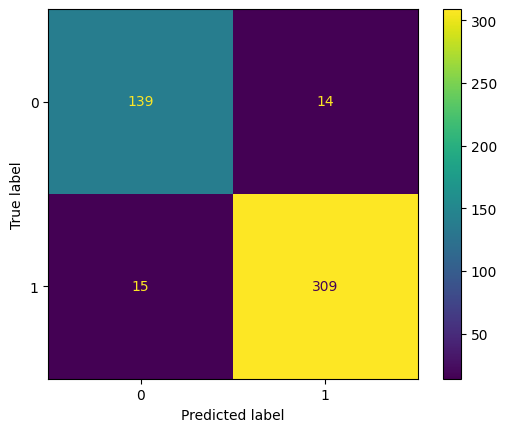

In [51]:
model_dt = grid_dt.best_estimator_
y_pred=  model_dt.predict(X_test)
y_prob = model_dt.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_dt.classes_)
disp.plot()
plt.show()

In [52]:
dt_report = classification_report(y_test, y_pred, output_dict=True)

In [54]:
importances = model_dt.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns[i] for i in indices]
importance_dict = {names[i]: importances[indices[i]] for i in range(len(names))}
importance_dict

{'year': 0.3152961424621079,
 'total_months': 0.30464853553274673,
 'month': 0.1635128649316709,
 'total_business_val': 0.11096483569578298,
 'city': 0.025801184516684686,
 'quarterly_rating_increased': 0.02082136861286916,
 'income': 0.015667468302837034,
 'age': 0.014989077899836764,
 'day': 0.013065349383809124,
 'quarterly_rating': 0.009323812662650722,
 'grade': 0.003408728740242829,
 'gender': 0.0025006312587611424,
 'income_increased': 0.0,
 'joining_designation': 0.0,
 'education': 0.0}

In [55]:
def eval_score(y_true, y_pred, y_prob=None):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, average='weighted')
    metrics['recall'] = recall_score(y_true, y_pred, average='weighted')
    metrics['f1'] = f1_score(y_true, y_pred, average='weighted')
    if y_prob is not None and len(set(y_true)) == 2:
        metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
    else:
        metrics['roc_auc'] = 'N/A'
    cm = confusion_matrix(y_true, y_pred)
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    if metrics['roc_auc'] != 'N/A':
        print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    return metrics


In [56]:
eval = eval_score(y_test, y_pred, y_prob=y_prob)

Accuracy: 0.9392
Precision: 0.9393
Recall: 0.9392
F1 Score: 0.9393
ROC-AUC: 0.9672

Confusion Matrix:
[[139  14]
 [ 15 309]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       153
           1       0.96      0.95      0.96       324

    accuracy                           0.94       477
   macro avg       0.93      0.93      0.93       477
weighted avg       0.94      0.94      0.94       477



In [57]:
with open("./decision_tree.pkl", "wb") as f:
  pickle.dump(model_dt, f)


#### Model 1 : RandomForestClassifier

In [58]:
# initialize model : finding best value for k with RF
# initialize model : model with defined classs_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

model1 = RandomForestClassifier(random_state=7, class_weight=class_weights_dict)

cv_scores = []
k_values=range(2, 10)
# selecting best value of k
for k in tqdm(k_values):
     kf=StratifiedKFold(n_splits=k,shuffle=True,random_state=7)
     scores=cross_val_score(model1, X_train, y_train,cv=kf)
     cv_scores.append(np.mean(scores))

# Find the best value of k
best_k = k_values[np.argmax(cv_scores)]
print(f"Best value of k: {best_k} with accuracy: {max(cv_scores):.4f}")

100%|██████████| 8/8 [00:16<00:00,  2.04s/it]

Best value of k: 8 with accuracy: 0.9128


In [59]:
kfold = StratifiedKFold(n_splits=best_k)

rf_clf = RandomForestClassifier(random_state=7, class_weight=class_weights_dict)
cv_results_rf = cross_validate(rf_clf, X_train, y_train, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_results_rf['train_score'].mean()*100:.2f} \n Validation: {cv_results_rf['test_score'].mean()*100:.2f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_results_rf['train_score'].std()*100:.2f}, \n Validation: {cv_results_rf['test_score'].std()*100:.2f}")


K-Fold Accuracy Mean: 
 Train: 100.00 
 Validation: 91.02
K-Fold Accuracy Std: 
 Train: 0.00, 
 Validation: 1.82


In [60]:
# initialize model : selecting best estimators
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 3, 5, 10, 20],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
random_search_rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=7, class_weight=class_weights_dict),
                                      param_distributions=params,
                                      n_iter=50,
                                      scoring='accuracy',
                                      cv=kfold,
                                      n_jobs=-1,
                                      random_state=7,
                                      verbose=1)
random_search_rf.fit(X_train, y_train)

Fitting 8 folds for each of 50 candidates, totalling 400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(class_weight={0: 1.5555555555555556,
                                                                  1: 0.7368421052631579},
                                                    random_state=7),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 3, 5, 10, 20],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=7, scoring='accuracy', verbose=1)

In [61]:
print("Best params: ", random_search_rf.best_params_)
print("Best score: ", random_search_rf.best_score_)

Best params:  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}
Best score:  0.9227941176470589


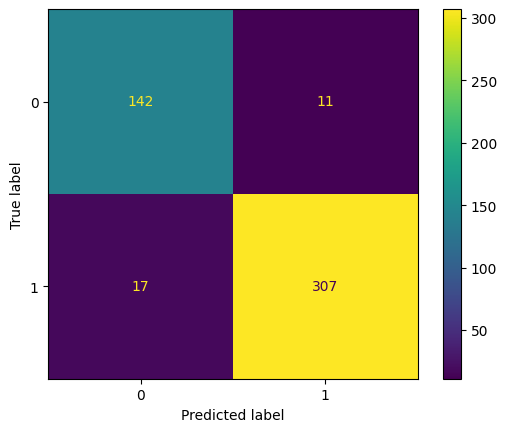

In [62]:
model_rf1 = random_search_rf.best_estimator_
y_pred=  model_rf1.predict(X_test)
y_prob = model_rf1.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_rf1.classes_)
disp.plot()
plt.show()

In [63]:
rf_model=classification_report(y_test, y_pred,output_dict=True)

In [64]:
importances = model_rf1.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns[i] for i in indices]
importance_dict = {names[i]: importances[indices[i]] for i in range(len(names))}
importance_dict


{'total_months': 0.2762874996233374,
 'year': 0.22463759174146616,
 'month': 0.13731009454112372,
 'total_business_val': 0.09171338188226821,
 'quarterly_rating_increased': 0.0628280676227688,
 'income': 0.048365688284573195,
 'city': 0.038589624698739326,
 'day': 0.03374440258725211,
 'quarterly_rating': 0.029771697888486052,
 'age': 0.028956622421779175,
 'education': 0.009371122959428655,
 'joining_designation': 0.006881330359547227,
 'grade': 0.006011781358779102,
 'gender': 0.005381662745797524,
 'income_increased': 0.00014943128465327968}

In [65]:
eval = eval_score(y_test, y_pred, y_prob=y_prob)

Accuracy: 0.9413
Precision: 0.9422
Recall: 0.9413
F1 Score: 0.9416
ROC-AUC: 0.9737

Confusion Matrix:
[[142  11]
 [ 17 307]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       153
           1       0.97      0.95      0.96       324

    accuracy                           0.94       477
   macro avg       0.93      0.94      0.93       477
weighted avg       0.94      0.94      0.94       477



In [66]:
with open("./random_forest.pkl", "wb") as f:
  pickle.dump(model_rf1, f)

> model with class_weight and model with SMOTE performs similar

#### Model 2 : GradientBoostingClassifier

#### Model 3 : XGBoost

In [67]:
# initialize model : finding best value for k with xgboost
# uing scale_pos_weight for class imbalance\\

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
scale_pos_weight = n_neg / n_pos

model4 = XGBClassifier(random_state=7, scale_pos_weight=scale_pos_weight)

cv_scores = []
k_values=range(2, 10)
# selecting best value of k
for k in tqdm(k_values):
     kf=StratifiedKFold(n_splits=k,shuffle=True,random_state=7)
     scores=cross_val_score(model4, X_train, y_train,cv=kf)
     cv_scores.append(np.mean(scores))

# Find the best value of k
best_k = k_values[np.argmax(cv_scores)]
print(f"Best value of k: {best_k} with accuracy: {max(cv_scores):.4f}")

100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

Best value of k: 7 with accuracy: 0.9228


In [68]:
# training the base model with optimal k
kfold = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=7)

xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=scale_pos_weight)
cv_results_rf = cross_validate(xgb_clf , X_train, y_train, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_results_rf['train_score'].mean()*100:.2f} \n Validation: {cv_results_rf['test_score'].mean()*100:.2f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_results_rf['train_score'].std()*100:.2f} \n Validation: {cv_results_rf['test_score'].std()*100:.2f}")

K-Fold Accuracy Mean: 
 Train: 99.99 
 Validation: 92.28
K-Fold Accuracy Std: 
 Train: 0.02 
 Validation: 1.93


In [69]:
# selecting best params for the estimator
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.01, 0.05, 0.1, 0.2],
    'reg_lambda': [1, 1.5, 2, 2.5, 3]
}
random_search_xgb = RandomizedSearchCV(estimator=XGBClassifier(random_state=7, scale_pos_weight=scale_pos_weight),
                                      param_distributions=params,
                                      n_iter=50,
                                      scoring='accuracy',
                                      cv=kfold,
                                      n_jobs=-1,
                                      random_state=7,
                                      verbose=1)

random_search_xgb.fit(X_train, y_train)


Fitting 7 folds for each of 50 candidates, totalling 350 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=7, random_state=7, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importanc...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=7, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 5, 7, 10, 15],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.01, 0.05, 0.1, 0.2],
                                        'reg_lambda': [1, 1.5, 2, 2.5, 3]},
                   random_state=7, scoring='accuracy', verbose=1)

In [70]:
print("Best params: ", random_search_xgb.best_params_)
print("Best score: ", random_search_xgb.best_score_)

Best params:  {'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0.1}
Best score:  0.9275210084033614


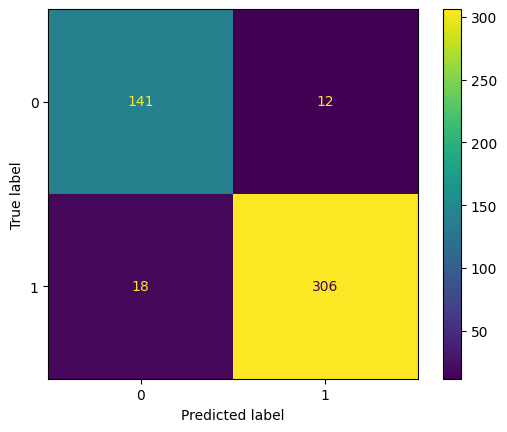

In [71]:
model_xgb = random_search_xgb.best_estimator_
y_pred=  model_xgb.predict(X_test)
y_prob=  model_xgb.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_xgb.classes_)
disp.plot()
plt.show()

In [72]:
xbg_model=classification_report(y_test, y_pred,output_dict=True)

In [73]:
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns[i] for i in indices]
importance_dict = {names[i]: importances[indices[i]] for i in range(len(names))}
importance_dict


{'quarterly_rating_increased': 0.38077533,
 'year': 0.22179574,
 'total_months': 0.12532492,
 'total_business_val': 0.06977713,
 'month': 0.06612738,
 'quarterly_rating': 0.019912347,
 'day': 0.01979753,
 'joining_designation': 0.01800122,
 'income': 0.014107578,
 'age': 0.014097258,
 'city': 0.013595751,
 'education': 0.013569589,
 'gender': 0.013169663,
 'grade': 0.009948607,
 'income_increased': 0.0}

In [74]:
eval = eval_score(y_test, y_pred, y_prob=y_prob)

Accuracy: 0.9371
Precision: 0.9381
Recall: 0.9371
F1 Score: 0.9374
ROC-AUC: 0.9707

Confusion Matrix:
[[141  12]
 [ 18 306]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       153
           1       0.96      0.94      0.95       324

    accuracy                           0.94       477
   macro avg       0.92      0.93      0.93       477
weighted avg       0.94      0.94      0.94       477



In [75]:
with open("./xgboost.pkl", "wb") as f:
  pickle.dump(model_xgb, f)

#### Model 4 : LightGBM

In [76]:
# initialize model : finding best value for k with GBDT

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

model5 = LGBMClassifier(random_state=7, class_weight=class_weights_dict)

cv_scores = []
k_values=range(2, 10)
# selecting best value of k
for k in tqdm(k_values):
     kf=StratifiedKFold(n_splits=k,shuffle=True,random_state=7)
     scores=cross_val_score(model5, X_train, y_train,cv=kf)
     cv_scores.append(np.mean(scores))

# Find the best value of k
best_k = k_values[np.argmax(cv_scores)]
print(f"Best value of k: {best_k} with accuracy: {max(cv_scores):.4f}")

  0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 646, number of negative: 306
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 646, number of negative: 306
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number o

 12%|█▎        | 1/8 [00:00<00:01,  3.77it/s]

[LightGBM] [Info] Number of positive: 861, number of negative: 408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499903 -> initscore=-0.000387
[LightGBM] [Info] Start training from score -0.000387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 861, number of negative: 408
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 14
[LightGBM] [Info] [

 25%|██▌       | 2/8 [00:00<00:01,  3.66it/s]

[LightGBM] [Info] Number of positive: 969, number of negative: 459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 969, number of negative: 459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 14
[LightGBM] [Info] [binary:Boos

 38%|███▊      | 3/8 [00:00<00:01,  3.09it/s]

[LightGBM] [Info] Number of positive: 969, number of negative: 459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 1428, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1034, number of negative: 489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 1523, number of used features: 15
[LightGBM] [Info] [binary:Boo

 50%|█████     | 4/8 [00:01<00:01,  2.61it/s]

[LightGBM] [Info] Number of positive: 1076, number of negative: 510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 1586, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499845 -> initscore=-0.000619
[LightGBM] [Info] Start training from score -0.000619
[LightGBM] [Info] Number of positive: 1076, number of negative: 510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 1586, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499845 -> initscore=-0.000619
[LightGBM] [

 62%|██████▎   | 5/8 [00:02<00:01,  2.16it/s]

[LightGBM] [Info] Number of positive: 1077, number of negative: 510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1587, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500077 -> initscore=0.000310
[LightGBM] [Info] Start training from score 0.000310
[LightGBM] [Info] Number of positive: 1108, number of negative: 524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 1632, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500401 -> initscore=0.001606
[LightGBM] [Inf

 75%|███████▌  | 6/8 [00:02<00:01,  1.89it/s]

[LightGBM] [Info] Number of positive: 1131, number of negative: 535
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500344 -> initscore=0.001376
[LightGBM] [Info] Start training from score 0.001376
[LightGBM] [Info] Number of positive: 1131, number of negative: 535
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 15
[LightGBM] [Info] [binary:Boos

 88%|████████▊ | 7/8 [00:03<00:00,  1.67it/s]

[LightGBM] [Info] Number of positive: 1130, number of negative: 536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499656 -> initscore=-0.001376
[LightGBM] [Info] Start training from score -0.001376
[LightGBM] [Info] Number of positive: 1130, number of negative: 536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499656 -> initscore=-0.001376
[LightGBM] [

100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

Best value of k: 7 with accuracy: 0.9254


In [77]:
# training the base model with optimal k
kfold = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=7)

lgbm_clf = LGBMClassifier(random_state=7, class_weight=class_weights_dict)
cv_results_rf = cross_validate(lgbm_clf , X_train, y_train, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_results_rf['train_score'].mean()*100:.2f} \n Validation: {cv_results_rf['test_score'].mean()*100:.2f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_results_rf['train_score'].std()*100:.2f} \n Validation: {cv_results_rf['test_score'].std()*100:.2f}")

[LightGBM] [Info] Number of positive: 1108, number of negative: 524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 1632, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500401 -> initscore=0.001606
[LightGBM] [Info] Start training from score 0.001606
[LightGBM] [Info] Number of positive: 1108, number of negative: 524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 1632, number of used features: 15
[LightGBM] [Info] [binary:Boos

In [78]:
# selecting best params for the estimator
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.05, 0.1, 0.2],
    'reg_lambda': [1, 1.5, 2, 2.5, 3]
}

random_search_lgbm = RandomizedSearchCV(estimator=LGBMClassifier(random_state=7, class_weight=class_weights_dict),
                                      param_distributions=params,
                                      n_iter=50,
                                      scoring='accuracy',
                                      cv=kfold,
                                      n_jobs=-1,
                                      random_state=7,
                                      verbose=1)

random_search_lgbm.fit(X_train, y_train)

Fitting 7 folds for each of 50 candidates, totalling 350 fits
[LightGBM] [Info] Number of positive: 1292, number of negative: 612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 1904, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

RandomizedSearchCV(cv=StratifiedKFold(n_splits=7, random_state=7, shuffle=True),
                   estimator=LGBMClassifier(class_weight={0: 1.5555555555555556,
                                                          1: 0.7368421052631579},
                                            random_state=7),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 5, 7, 10, 15],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.01, 0.05, 0.1, 0.2],
                                        'reg_lambda': [1, 1.5, 2, 2.5, 3]},
                   random_state=7, scoring='accuracy', verbose=1)

In [79]:
print("Best params: ", random_search_lgbm.best_params_)
print("Best score: ", random_search_lgbm.best_score_)

Best params:  {'reg_lambda': 2.5, 'reg_alpha': 0.01, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.05}
Best score:  0.9275210084033614


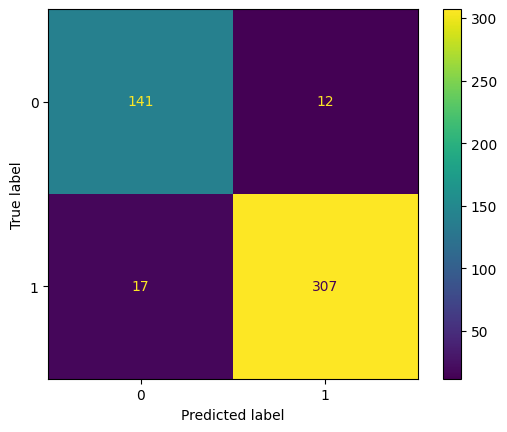

In [80]:
model_lgbm = random_search_lgbm.best_estimator_
y_pred=  model_lgbm.predict(X_test)
y_prob=  model_lgbm.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_lgbm.classes_)
disp.plot()
plt.show()

In [81]:
lgbm_model=classification_report(y_test, y_pred,output_dict=True)

In [82]:
importances = model_lgbm.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns[i] for i in indices]
importance_dict = {names[i]: importances[indices[i]] for i in range(len(names))}
importance_dict

{'income': 1922,
 'city': 1412,
 'day': 1368,
 'month': 1364,
 'total_months': 1336,
 'age': 1149,
 'total_business_val': 809,
 'quarterly_rating': 720,
 'year': 616,
 'education': 267,
 'joining_designation': 218,
 'quarterly_rating_increased': 210,
 'gender': 176,
 'grade': 145,
 'income_increased': 0}

In [83]:
eval = eval_score(y_test, y_pred, y_prob=y_prob)

Accuracy: 0.9392
Precision: 0.9399
Recall: 0.9392
F1 Score: 0.9395
ROC-AUC: 0.9699

Confusion Matrix:
[[141  12]
 [ 17 307]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       153
           1       0.96      0.95      0.95       324

    accuracy                           0.94       477
   macro avg       0.93      0.93      0.93       477
weighted avg       0.94      0.94      0.94       477



In [84]:
with open("./lighgbm.pkl", "wb") as f:
  pickle.dump(model_lgbm, f)


In [85]:
# aggregating all the reports in one DF
reports_df = {}

models =["DecisionTree", "RandomForest", "XGBoost", "LightGBM"]
reports =[dt_report, rf_model,xbg_model,lgbm_model]

for model, r in zip(models,reports):
    try:
        temp = pd.DataFrame(r).transpose()
        temp['model']=model
        reports_df[model]=temp
    except:
        continue
    # break



In [86]:
final_df = pd.concat(reports_df.values()).reset_index()
cols = final_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
final_df = final_df[cols]

In [144]:
final_df.to_csv("./eval_metrics.csv")